In [121]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import itertools
import networkx as nx
import sys

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import radius_neighbors_graph
import sklearn.neighbors
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm

from mpl_toolkits.mplot3d import Axes3D
sys.path.append("../")
import utils as ut
from importlib import reload
reload(ut)


<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/turingModels/../utils.py'>

In [2]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'global' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()
df.head()

df.shape=(7418, 13)
key
HFD8     3391
ND       2034
HFD14    1993
Name: count, dtype: int64



,spotId,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,Stromal cells,Dendritic cells,Mac4,Mac2,Mac5,key
0,AAACAAGTATCTCCCA.1_ND,0.018691,0.009410,0.010737,0.070782,0.040298,0.077389,0.645332,0.015281,0.045516,0.039354,0.027211,ND
1,AAACAGCTTTCAGAAG.1_ND,0.008378,0.005700,0.038038,0.089932,0.048618,0.103983,0.575021,0.046758,0.020027,0.035451,0.028094,ND
2,AAACAGGGTCTATATT.1_ND,0.024325,0.010761,0.024323,0.117606,0.072993,0.121093,0.478383,0.026608,0.042051,0.048258,0.033598,ND
3,AAACATTTCCCGGATT.1_ND,0.023002,0.014704,0.044181,0.087019,0.053537,0.083922,0.465958,0.053223,0.087758,0.037452,0.049242,ND
4,AAACCCGAACGAAATC.1_ND,0.021954,0.003784,0.001240,0.038020,0.026386,0.061364,0.775170,0.003725,0.023106,0.025914,0.019336,ND


In [3]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "global" in f:
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        sdf = ut.normalize(sdf, 1e6)
        spt[key] = sdf
        print(f, sdf.shape)
    
print('done')

HFD8_global_spt.csv (3394, 31053)
ND_global_spt.csv (2036, 31053)
HFD14_global_spt.csv (1994, 31053)
done


In [4]:
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f and "global" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()
cdf.head()

cdf.shape=(7424, 4)
key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64



,spotId,x,y,key
0,AAACAAGTATCTCCCA.1_HFD8,1244.795278,1189.669724,HFD8
1,AAACACCAATAACTGC.1_HFD8,405.548324,1349.579809,HFD8
2,AAACAGCTTTCAGAAG.1_HFD8,303.880251,1068.178931,HFD8
3,AAACAGGGTCTATATT.1_HFD8,344.496391,1138.478061,HFD8
4,AAACAGTGTTCCTGGG.1_HFD8,648.734268,1595.524585,HFD8


In [5]:
"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates() # very important!
print(df['key'].value_counts())
df.head()

key
HFD8     3394
ND       2036
HFD14    1994
Name: count, dtype: int64


,spotId,x,y,key,B cells,Mac1,Mac3,Monocytes,T cells,NK cells,Stromal cells,Dendritic cells,Mac4,Mac2,Mac5
0,AAACAAGTATCTCCCA.1_HFD8,1244.795278,1189.669724,HFD8,0.077635,0.022735,0.104811,0.111453,0.125867,0.195064,0.059765,0.111978,0.082445,0.066571,0.041676
1,AAACACCAATAACTGC.1_HFD8,405.548324,1349.579809,HFD8,0.076987,0.041831,0.047343,0.139484,0.082711,0.093085,0.148247,0.071763,0.058744,0.142045,0.097760
2,AAACAGCTTTCAGAAG.1_HFD8,303.880251,1068.178931,HFD8,0.079216,0.043327,0.075868,0.086821,0.086695,0.097747,0.186142,0.090520,0.069670,0.094246,0.089748
3,AAACAGGGTCTATATT.1_HFD8,344.496391,1138.478061,HFD8,0.037682,0.029618,0.093281,0.109521,0.052151,0.061401,0.201332,0.094533,0.143671,0.088173,0.088637
4,AAACAGTGTTCCTGGG.1_HFD8,648.734268,1595.524585,HFD8,0.092691,0.001555,0.002745,0.075636,0.054631,0.052849,0.112912,0.008552,0.258918,0.056771,0.282740


kdf.shape=(3394, 16)
n nodes: 30 at distance: 50
adj.shape=(30, 30)


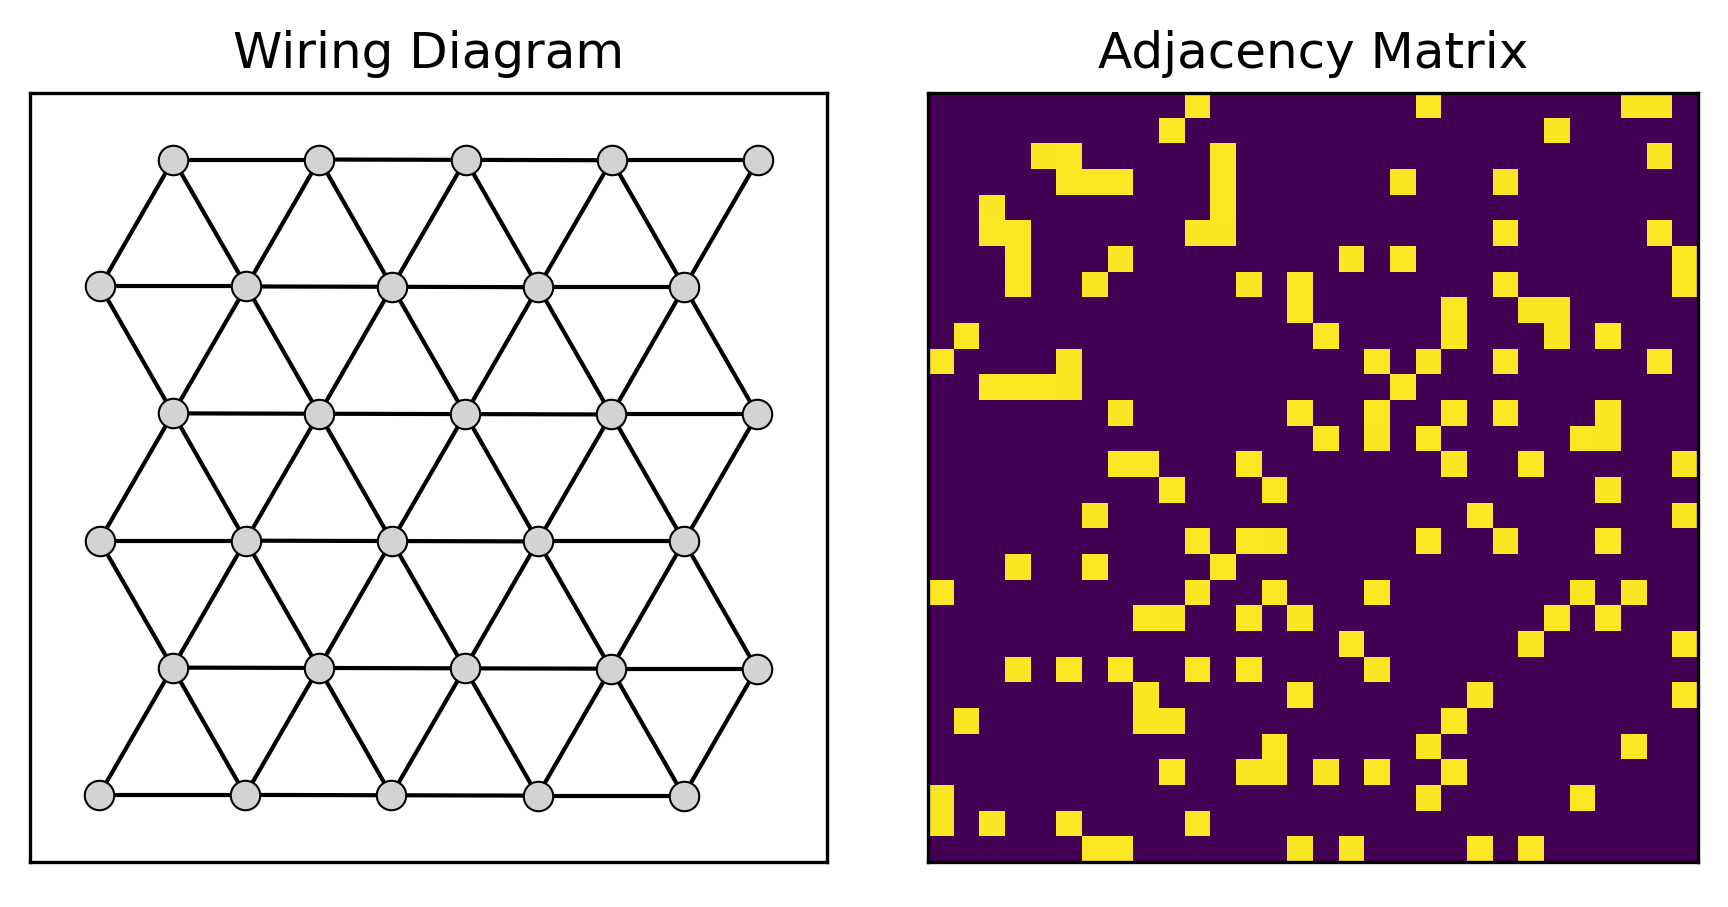

In [9]:
# build a simplified network from a small set of spots

key = 'HFD8'
radius = 50 # spots within this distance from the center x,y coord are considered

# get the experimental condition
kdf = df[df['key'] == key].reset_index()
print(f"{kdf.shape=}")

centerX = kdf['x'].mean()
centerY = kdf['y'].mean()

mask = (kdf['x'] > (centerX - radius)) \
        & (kdf['x'] < (centerX + radius)) \
        & (kdf['y'] > (centerY - radius)) \
        & (kdf['y'] < (centerY + radius)) \

gdf = kdf[mask].reset_index()
print(f"n nodes: {len(gdf)} at distance: {radius}")


def getGraph(gdf, r=25):
    """A function to generate a graph of size n x n
    around point (x, y) """
    
    # get the full distance matrix
    nodes = gdf[['x', 'y']]
    X = sklearn.metrics.pairwise_distances(nodes, metric='minkowski')
    
    # drop edges beyond a radius
    X = np.where(X > r, 0, X)
    np.fill_diagonal(X, 0) # remove self-loops
    
    # create the graph
    G = nx.Graph()
    G.add_nodes_from(list(range(X.shape[0])))
    
    # get valid edges
    Xsparse = scipy.sparse.coo_matrix(X)
    edges = list(zip(Xsparse.row, Xsparse.col, Xsparse.data))

    G.add_weighted_edges_from(edges)
    
    # rename nodes
    nodeMapper = dict(zip(gdf.index, gdf['spotId']))
    G = nx.relabel_nodes(G, nodeMapper)
    
    # create dataframe
    adj = pd.DataFrame(X, index=gdf['spotId'], columns=gdf['spotId'])
    
    # set positions
    pos = {}
    for idx, row in gdf.iterrows():
        pos[row['spotId']] = np.array(row[['x', 'y']])
    
    G.pos = pos
    return G, adj

# # get adjancency matrix
G, adj = getGraph(gdf)
print(f"{adj.shape=}")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 2)

nx.draw_networkx_nodes(G,
                   pos=G.pos,
                   node_size=50,
                   node_color='lightgrey',
                   edgecolors='k',
                   linewidths=0.5,
                   ax=axs[0])

nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=1,
                       edge_color='k',
                       ax=axs[0])


axs[0].set_aspect('equal')
axs[0].set_title('Wiring Diagram')

axs[1].imshow(adj)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Adjacency Matrix')
plt.tight_layout()

kdf.shape=(3394, 16)
n nodes: 30 at distance: 50
kdf.shape=(3394, 16)
n nodes: 30 at distance: 50
adj.shape=(30, 30)


/tmp/ipykernel_2068531/2959333284.py:57: RuntimeWarning: divide by zero encountered in true_divide
  X = np.where(X > 0, 1/X, X)


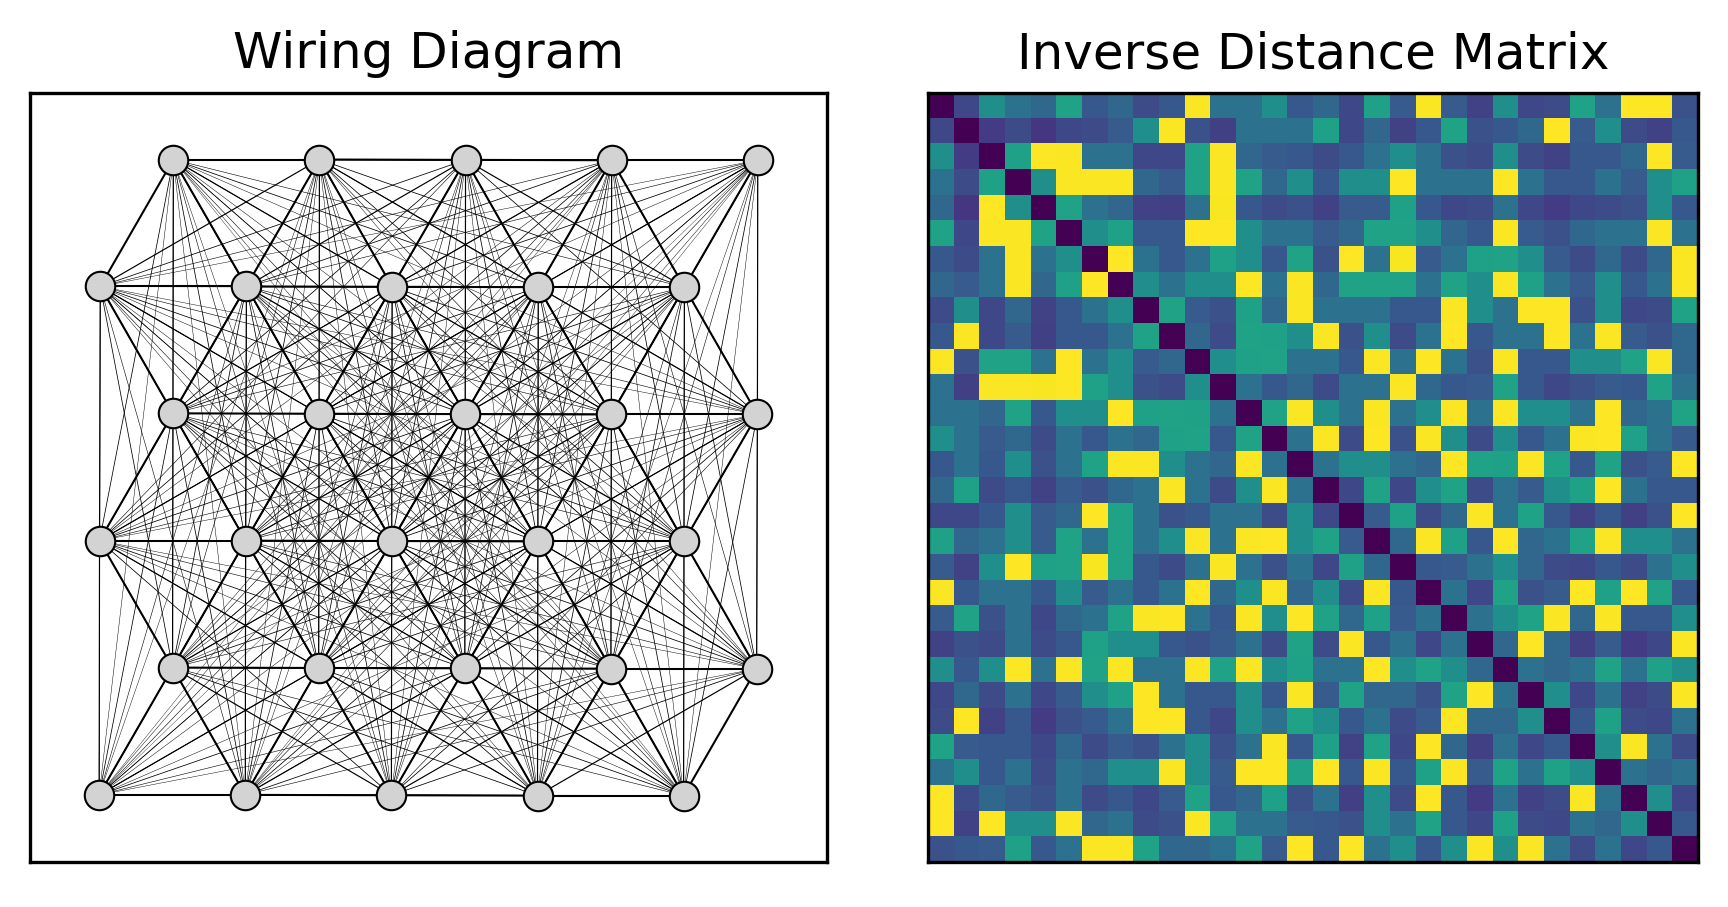

In [20]:
# a second example, where the the full inverse distance matrix is considered


# build a simplified network from a small set of spots

key = 'HFD8'
radius = 50 # spots within this distance from the center x,y coord are considered

# get the experimental condition
kdf = df[df['key'] == key].reset_index()
print(f"{kdf.shape=}")

centerX = kdf['x'].mean()
centerY = kdf['y'].mean()

mask = (kdf['x'] > (centerX - radius)) \
        & (kdf['x'] < (centerX + radius)) \
        & (kdf['y'] > (centerY - radius)) \
        & (kdf['y'] < (centerY + radius)) \

gdf = kdf[mask].reset_index()
print(f"n nodes: {len(gdf)} at distance: {radius}")


# build a simplified network from a small set of spots

key = 'HFD8'
radius = 50 # spots within this distance from the center x,y coord are considered

# get the experimental condition
kdf = df[df['key'] == key].reset_index()
print(f"{kdf.shape=}")

centerX = kdf['x'].mean()
centerY = kdf['y'].mean()

mask = (kdf['x'] > (centerX - radius)) \
        & (kdf['x'] < (centerX + radius)) \
        & (kdf['y'] > (centerY - radius)) \
        & (kdf['y'] < (centerY + radius)) \

gdf = kdf[mask].reset_index()
print(f"n nodes: {len(gdf)} at distance: {radius}")


def getGraph_full(gdf):
    """A function to generate a graph of size n x n
    around point (x, y) """
    
    # get the full distance matrix
    nodes = gdf[['x', 'y']]
    X = sklearn.metrics.pairwise_distances(nodes, metric='minkowski')
    
    np.fill_diagonal(X, 0) # remove self-loops
    
    # invert the distances
    X = np.where(X > 0, 1/X, X)
    
    
    # create the graph
    G = nx.from_numpy_array(X)
    
    # rename nodes
    nodeMapper = dict(zip(gdf.index, gdf['spotId']))
    G = nx.relabel_nodes(G, nodeMapper)
    
    # create dataframe
    adj = pd.DataFrame(X, index=gdf['spotId'], columns=gdf['spotId'])
    
    # set positions
    pos = {}
    for idx, row in gdf.iterrows():
        pos[row['spotId']] = np.array(row[['x', 'y']])
    
    G.pos = pos
    return G, adj

# # get adjancency matrix
G, adj = getGraph_full(gdf)
print(f"{adj.shape=}")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 2)

nx.draw_networkx_nodes(G,
                   pos=G.pos,
                   node_size=50,
                   node_color='lightgrey',
                   edgecolors='k',
                   linewidths=0.5,
                   ax=axs[0])


eweights = [w['weight']*10 for (u, v, w) in G.edges(data=True)]

nx.draw_networkx_edges(G,
                       pos=G.pos,
                       width=eweights,
                       edge_color='k',
                       ax=axs[0])


axs[0].set_aspect('equal')
axs[0].set_title('Wiring Diagram')

axs[1].imshow(adj)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Inverse Distance Matrix')
plt.tight_layout()


In [136]:
# buld some linear models for cell-cell interactions

train_on = ['Monocytes', 'Mac1']
key = 'HFD8'

# get the experimental condition
kdf = df[df['key'] == key].reset_index(drop=True)
print(f"{kdf.shape=}")
knn = len(kdf) - 1

radii = np.linspace(21, 100, 5)


nodes = kdf[['x', 'y']]
# get the n points around that node
nbrs = NearestNeighbors(n_neighbors=knn,  
                        metric='minkowski', 
                        algorithm='ball_tree').fit(nodes)


# get neighborhoods at different scales
neighborhood = {}
for r in radii:
    knnind = nbrs.radius_neighbors(nodes,
                                   return_distance=False,
                                   radius=r)
    neighborhood[r] = knnind
    

res = []
for idx, row in kdf.iterrows():
    
    # loop through each radius
    for r in radii:
        knnind =  neighborhood[r][idx] # get neighborhhood around point
        knndf = kdf[kdf.index.isin(knnind)][train_on].std(axis=0)
        
        # loop through all cell type pairs
        for (i, j) in itertools.permutations(train_on, 2):
            
            newRow = {
                'y' : row[i],
                'x' : knndf[j],
                'i' : i,
                'j' : j,
                'r' : r,
            }
            
            res.append(newRow)
    
res = pd.DataFrame(res)
res.head()

kdf.shape=(3394, 15)


,y,x,i,j,r
0,0.111453,0.010006,Monocytes,Mac1,21.00
1,0.022735,0.045234,Mac1,Monocytes,21.00
2,0.111453,0.022928,Monocytes,Mac1,40.75
3,0.022735,0.052870,Mac1,Monocytes,40.75
4,0.111453,0.029294,Monocytes,Mac1,60.50


In [134]:
pdf = res.copy()

models = {}

# fit some models
for (i, j) in itertools.permutations(train_on, 2):
    
    print(f"pedict {i} based on {j}")
    
    xdf = pdf[(pdf['i'] == i) & (pdf['j'] == j) ][['y', 'x', 'r']]
    xdf = pd.pivot_table(xdf, values='x', index='y', columns='r').reset_index(drop=False)
    
    X, X_test, y, y_test = train_test_split(xdf[radii], xdf['y'], test_size=0.33)
    # reg = svm.SVR()
    reg = sklearn.linear_model.LinearRegression()
    reg.fit(X, y)
    pred = reg.predict(X_test)
    
    plt.scatter(pred, y_test, s=3, alpha=.5)
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.title(f"{i,j}")
    plt.show()
    
    # print(xdf)
    # break


pedict Monocytes based on Mac1


KeyError: '[20.0] not in index'

In [92]:
xdf.columns

Index(['y', 21.0, 40.5, 60.0], dtype='object', name='r')

<AxesSubplot: xlabel='60', ylabel='y'>

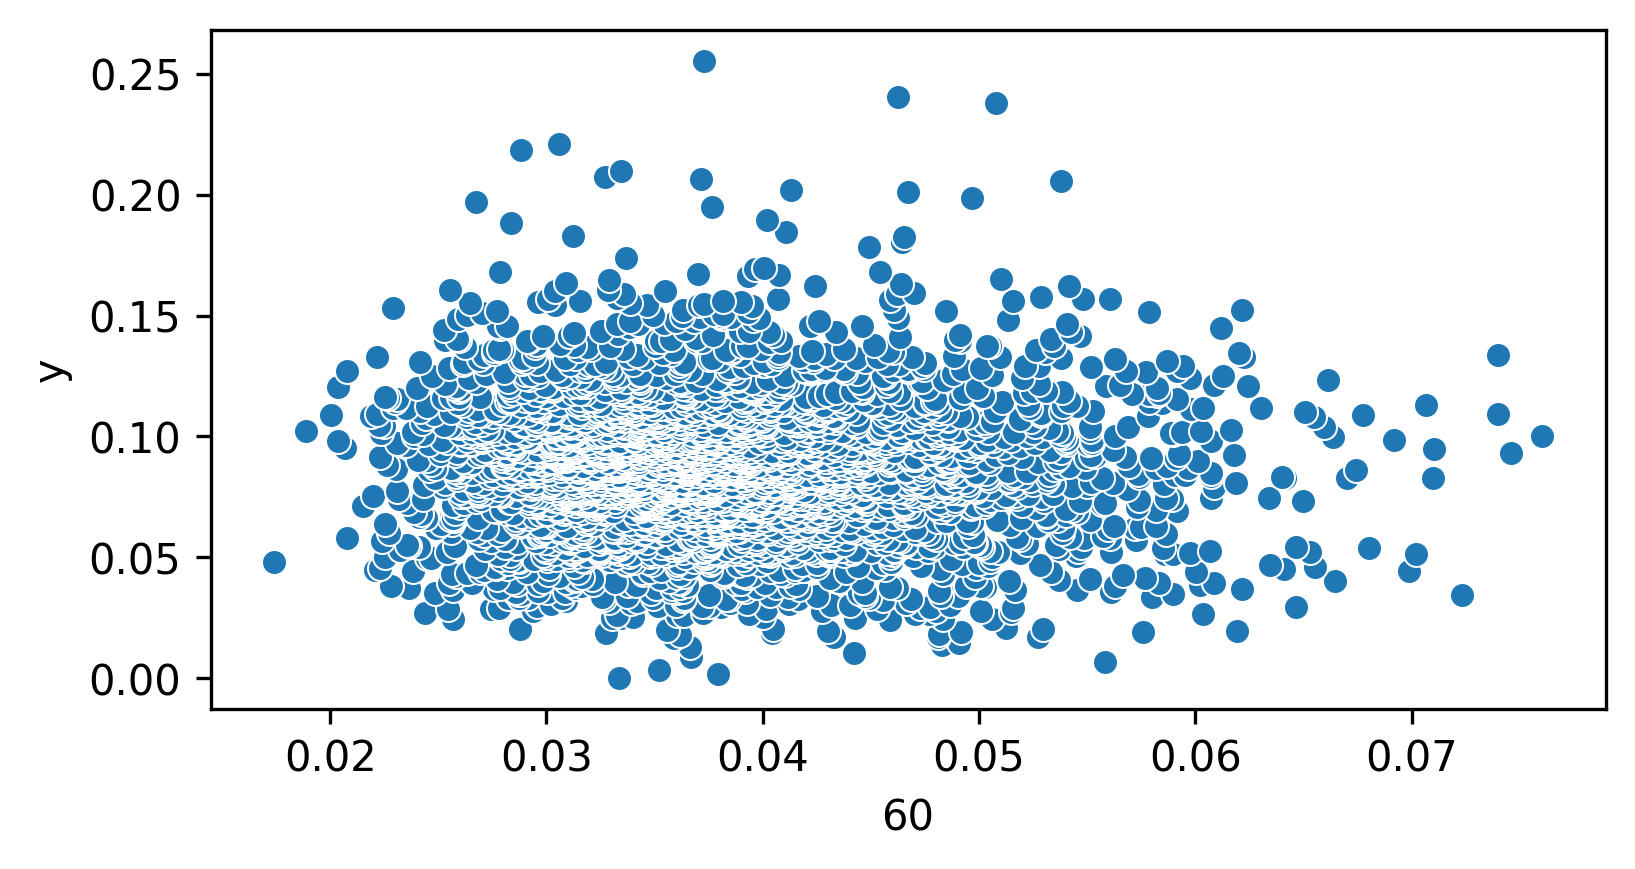

In [95]:
sns.scatterplot(data=xdf, 
                x=60,
                y='y')

In [135]:
xdf.columns

Index(['y', 40.0, 60.0, 80.0, 100.0], dtype='object', name='r')

In [ ]:
train_on = ['Monocytes', 'Dendritic cells', 'Mac1']